# Gaussian process

https://gist.github.com/anonymous/a040ccd6b9aaca9f9f85bef5ef5cece7

In [1]:
%matplotlib inline  
import numpy as np
import matplotlib.pyplot as plt
import functools
# from scipy.spatial.distance import cdist

In [2]:
# calc pairwise distance
# this function is same as cdist()
def dist_matrix(a, b):
    a = a.reshape(a.shape[0], 1, -1)
    b = b.reshape(1, b.shape[0], -1)
    return np.sqrt(np.sum((a-b)**2, axis=2))

In [3]:
# Squared Exponential (SE) kernel
def kernel_se(X1, X2, gain, length):
    """
    return k(X1, X2)
    
    Args:
        X1, X2: input data points
        gain: variance 가 gain 에 비례한대.
        length: 커널이 얼마나 smooth 할지를 나타냄
    """
    gain = gain**2
    length = 1. / length
    if X1.ndim <= 1:
        X1 = X1.reshape(-1, 1)
    if X2.ndim <= 1:
        X2 = X2.reshape(-1, 1)
    
    pairwise_dists = dist_matrix(X1, X2)
    K = gain*np.exp(-pairwise_dists ** 2/(length**2))

    return K

In [4]:
X_train = np.array([[1, 2, 3, 4, 6, 7, 9, 10]], dtype=np.float64).T
y_train = np.array([[2, 4, 5, 1, 3, 9, 4, 5]], dtype=np.float64).T
y_train -= y_train.mean() # zero-mean

In [5]:
y_train.mean()

0.0

In [6]:
X_train.flatten()

array([  1.,   2.,   3.,   4.,   6.,   7.,   9.,  10.])

Text(0.5,1,u'Training data')

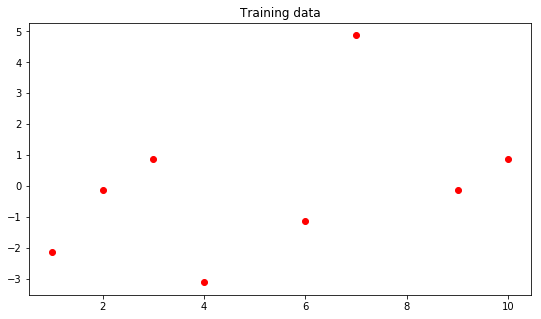

In [7]:
plt.figure(1, figsize=(9,5))
plt.plot(X_train.flatten(), y_train.flatten(), 'ro', label='Original data')
plt.title('Training data')

### GP formula

![GP](GP.png)

In [8]:
# Kernel hyperparams
gain = 5.
length = 0.5
s2w = 1e-8 # measurement noise

# get kernel which uses above hyperparams
kernel = functools.partial(kernel_se, gain=gain, length=length)

# Test inputs
N = 100
X_test = np.linspace(0, 10, N).reshape(-1, 1)

# GPR: Gaussian process regression

# measurement noise
m_noise = s2w * np.eye(X_train.shape[0])
# k(xs, xs)
Kss = kernel(X_test, X_test)
# k(xs, X)
Ksx = kernel(X_test, X_train)
# k(X, xs): 그냥 Ksx transpose 하면 됨
# Kxs = kernel(X_train, X_test)
Kxs = Ksx.T
# k(X, X)
Kxx = kernel(X_train, X_train)
Kxx += m_noise # add measurement noise
Kxx_inv = np.linalg.inv(Kxx)

'''
mean = Ksx @ Kxx_inv @ y_train
cov = Kss - Ksx @ Kxx_inv @ Kxs
'''

mean = np.matmul(np.matmul(Ksx, Kxx_inv), y_train)
cov = Kss - np.matmul(np.matmul(Ksx, Kxx_inv), Kxs)
var = np.diag(cov).reshape(-1, 1) # 이건 어디서 나오징
var_nz = var.copy()
var_nz[var < 0.] = 0. # for numerical stability
stddev = np.sqrt(var_nz)

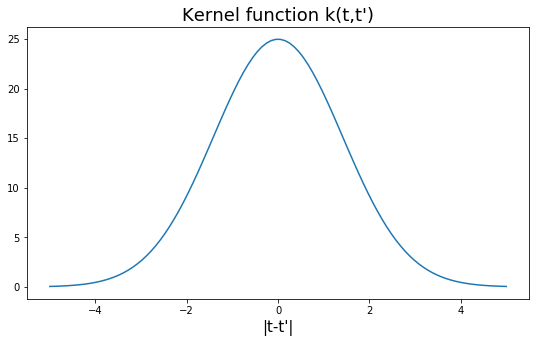

In [9]:
# Kernel plot
plt.figure(1, figsize=(9,5))
a = np.linspace(-5,5, N).reshape((-1,1))
b = kernel_se(np.zeros(1), a, gain=gain, length=length).reshape((-1,1))
plt.plot(a,b)
plt.title("Kernel function k(t,t')", fontsize=18)
plt.xlabel("|t-t'|", fontsize=15)
plt.show()

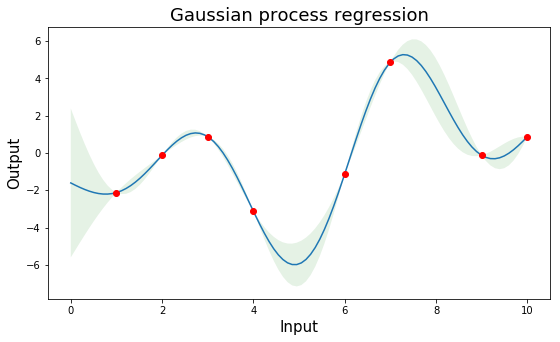

In [10]:
# GPR plot
plt.figure(2, figsize=(9,5))
plt.fill_between(X_test.squeeze(), (mean-2.0*stddev).squeeze(),(mean+2.0*stddev).squeeze(),
            facecolor='g', interpolate=True, alpha=0.1)
plt.plot(X_test, mean)
plt.plot(X_train.flatten(), y_train.flatten(), 'ro', label='Original data')
plt.title('Gaussian process regression', fontsize=18)
plt.xlabel('Input', fontsize=15)
plt.ylabel('Output', fontsize=15)
plt.show()